# DonorsChoose

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import math as ma

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

E:\Programs\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


##  1. Reading Data

In [2]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)
project_data.head(2)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                             0                    0  
1                                             7                    1

In [4]:
print("Number of data points in resourse train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in resourse train data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

## 2. Removing Duplicates 

First combine projects and resources

In [5]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')
print(project_data.shape)

(109248, 19)


In [6]:
#Are their any duplicates same essays, project titles, cost, quantity and teacher in the data?
sorted_data=project_data.sort_values('project_title', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
bool_series = sorted_data[["project_title","teacher_id","school_state","project_essay_1","project_essay_2","project_essay_3","project_essay_4","price","quantity"]].duplicated(keep=False) 
sorted_data[bool_series]

Unnamed: 0       id                        teacher_id teacher_prefix  \
105890      135375  p031163  a1ac9e40c0fd222153380491f2354c8e           Mrs.   
69781        99030  p085192  a1ac9e40c0fd222153380491f2354c8e           Mrs.   
95014       171243  p103848  e0840936cd050c5995b8a9622952b9b9            Mr.   
34032       171640  p217863  e0840936cd050c5995b8a9622952b9b9            Mr.   
71552        31570  p251176  bd33c4e96d29173282f35b26df9de481            Ms.   
77471         9086  p015266  bd33c4e96d29173282f35b26df9de481            Ms.   
68304       139161  p093540  bd33c4e96d29173282f35b26df9de481            Ms.   
20971       102904  p018814  119707593fc6f78bbba6e5c50173f236           Mrs.   
20743        13433  p183181  119707593fc6f78bbba6e5c50173f236           Mrs.   
5283        100090  p046627  299aa8570c30fc482b75bf32183fa6c5            Ms.   
16255       167072  p148564  299aa8570c30fc482b75bf32183fa6c5            Ms.   
38798       131740  p201524  9ee677c6530a33dea52491fc6d9d9fad            Ms.   
47312       124740  p175263  9ee677c6530a33dea52491fc6d9d9fad            Ms.   
97851       123637  p168484  3cf6707010632c8fdb1f85a07869e471           Mrs.   
48265        98988  p210208  3cf6707010632c8fdb1f85a07869e471           Mrs.   

       school_state project_submitted_datetime project_grade_category  \
105890           NY        2016-12-06 10:17:35             Grades 6-8   
69781            NY        2016-12-06 10:21:08             Grades 6-8   
95014            TX        2017-01-09 16:46:24            Grades 9-12   
34032            TX        2017-01-09 16:37:54            Grades 9-12   
71552            ID        2017-02-05 14:59:58          Grades PreK-2   
77471            ID        2017-02-05 15:02:44          Grades PreK-2   
68304            ID        2017-02-05 15:04:53          Grades PreK-2   
20971            TX        2017-02-15 23:14:21             Grades 3-5   
20743            TX        2017-02-15 23:22:57             Grades 3-5   
5283             NV        2016-12-03 21:25:22          Grades PreK-2   
16255            NV        2016-12-03 21:14:44          Grades PreK-2   
38798            AZ        2016-12-06 22:42:52             Grades 6-8   
47312            AZ        2016-12-06 22:40:17             Grades 6-8   
97851            PA        2016-08-04 19:34:34             Grades 3-5   
48265            PA        2016-07-30 15:54:32             Grades 3-5   

                 project_subject_categories  \
105890                  Literacy & Language   
69781                   Literacy & Language   
95014                        Math & Science   
34032                        Math & Science   
71552                   Literacy & Language   
77471                   Literacy & Language   
68304                   Literacy & Language   
20971   Literacy & Language, Math & Science   
20743                        Math & Science   
5283                    Literacy & Language   
16255                   Literacy & Language   
38798      History & Civics, Math & Science   
47312      History & Civics, Math & Science   
97851   Literacy & Language, Math & Science   
48265   Literacy & Language, Math & Science   

             project_subject_subcategories  \
105890      Literacy, Literature & Writing   
69781       Literacy, Literature & Writing   
95014        Applied Sciences, Mathematics   
34032        Applied Sciences, Mathematics   
71552                             Literacy   
77471                             Literacy   
68304                             Literacy   
20971    Literature & Writing, Mathematics   
20743   Health & Life Science, Mathematics   
5283                         ESL, Literacy   
16255                        ESL, Literacy   
38798      Financial Literacy, Mathematics   
47312      Financial Literacy, Mathematics   
97851    Literature & Writing, Mathematics   
48265    Literature & Writing, Mathematics   

                                project_title  \
105890             

We see that although the project id and time are different. These projects are essentially the same as the essays, cost, quantity, project title etc are excatly same. Therefore we remove the dupilcates from them.

In [7]:
project_data=project_data.drop_duplicates(subset={"project_title","teacher_id","school_state","project_essay_1","project_essay_2","project_essay_3","project_essay_4","price","quantity"}, keep='first', inplace=False)
print(project_data.shape)


(109240, 19)


In [8]:
#Are their any duplicates of same projects in the data?
sorted_data=project_data.sort_values('id', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
bool_series = sorted_data[["id"]].duplicated(keep=False) 
sorted_data[bool_series]

Empty DataFrame
Columns: [Unnamed: 0, id, teacher_id, teacher_prefix, school_state, project_submitted_datetime, project_grade_category, project_subject_categories, project_subject_subcategories, project_title, project_essay_1, project_essay_2, project_essay_3, project_essay_4, project_resource_summary, teacher_number_of_previously_posted_projects, project_is_approved, price, quantity]
Index: []

In [9]:
#Are their any duplicates same teacher posting at same time?
sorted_data=project_data.sort_values('project_submitted_datetime', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
bool_series = sorted_data[["project_submitted_datetime","teacher_id"]].duplicated(keep=False) 
sorted_data[bool_series]

Empty DataFrame
Columns: [Unnamed: 0, id, teacher_id, teacher_prefix, school_state, project_submitted_datetime, project_grade_category, project_subject_categories, project_subject_subcategories, project_title, project_essay_1, project_essay_2, project_essay_3, project_essay_4, project_resource_summary, teacher_number_of_previously_posted_projects, project_is_approved, price, quantity]
Index: []

In [10]:
#have different teachers posted same project?
sorted_data=project_data.sort_values('project_title', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
bool_series = sorted_data[["project_title","school_state","project_essay_1","project_essay_2","project_essay_3","project_essay_4","price","quantity"]].duplicated(keep=False) 
sorted_data[bool_series]

Unnamed: 0       id                        teacher_id teacher_prefix  \
35481      164898  p019084  6f3f0e6dcadc61f516b10efa8613ed6d           Mrs.   
78408      166527  p243927  9fc77e9bbfbc40a689b3474a0fede264            Ms.   

      school_state project_submitted_datetime project_grade_category  \
35481           MA        2016-11-03 20:33:01             Grades 6-8   
78408           MA        2016-11-03 17:00:28             Grades 6-8   

      project_subject_categories project_subject_subcategories  \
35481        Literacy & Language                      Literacy   
78408        Literacy & Language                      Literacy   

                                         project_title  \
35481  Close the Gap with Digital 21st Century Skills!   
78408  Close the Gap with Digital 21st Century Skills!   

                                         project_essay_1  \
35481  My 7th graders are curious, enthusiastic, and ...   
78408  My 7th graders are curious, enthusiastic, and ...   

                                         project_essay_2 project_essay_3  \
35481  Chromebooks would be used in the classroom on ...             NaN   
78408  Chromebooks would be used in the classroom on ...             NaN   

      project_essay_4                           project_resource_summary  \
35481             NaN  My students need access to computers in the cl...   
78408             NaN  My students need access to computers in the cl...   

       teacher_number_of_previously_posted_projects  project_is_approved  \
35481                                             0                    1   
78408                                             0                    1   

        price  quantity  
35481  190.42        10  
78408  190.42        10

We remove this duplication because it is essentially same project

In [11]:
project_data=project_data.drop_duplicates(subset={"project_title","school_state","project_essay_1","project_essay_2","project_essay_3","project_essay_4","price","quantity"}, keep='first', inplace=False)
print(project_data.shape)


(109239, 19)


In [12]:
#Duplicates with essentially the same content but a slightly different project title
sorted_data=project_data.sort_values('teacher_id', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
bool_series = sorted_data[["school_state","project_grade_category","project_essay_1","project_essay_2","project_essay_3","project_essay_4","price","quantity"]].duplicated(keep=False) 
sorted_data[bool_series]

Unnamed: 0       id                        teacher_id teacher_prefix  \
106368      165106  p077552  0b970008579b1930b28b49957348a2fa           Mrs.   
104334      134224  p105628  0b970008579b1930b28b49957348a2fa           Mrs.   
47357       103101  p037737  0cb366a6c4d01fa08715a213d182ce77            Mr.   
32348       175070  p004681  0cb366a6c4d01fa08715a213d182ce77            Mr.   
62152        13798  p225961  0cb366a6c4d01fa08715a213d182ce77            Mr.   
5760         56280  p229224  0cb366a6c4d01fa08715a213d182ce77            Mr.   
93915       103191  p012433  0cb366a6c4d01fa08715a213d182ce77            Mr.   
99490         8339  p246152  0de5b9af44dc5768d3b16f8ef3e5d46a           Mrs.   
100873      158420  p152464  0de5b9af44dc5768d3b16f8ef3e5d46a           Mrs.   
77183        55122  p186301  18f8f6f2b8b2208339780a34dae71e57            Ms.   
34175       164499  p106340  18f8f6f2b8b2208339780a34dae71e57            Ms.   
45124       133393  p012980  1991e6176ac525215f795f6cb126fb8d            Ms.   
13983       167757  p116681  1991e6176ac525215f795f6cb126fb8d            Ms.   
27297        69581  p024185  1d77f2a0e6d38b65f2691b8b32dfdd10            Ms.   
77766        41271  p083353  1d77f2a0e6d38b65f2691b8b32dfdd10            Ms.   
56889       147571  p178968  21c0ecd4eca2b9713af1e3e86d4d824d           Mrs.   
32901         1208  p033211  2456da41b18d783a2f405df74d48c2f1           Mrs.   
25074        47503  p050556  2456da41b18d783a2f405df74d48c2f1           Mrs.   
53984        55051  p021892  2c0042f52977532e277b0b7a6c7416cc            Mr.   
8296        144094  p091120  2c0042f52977532e277b0b7a6c7416cc            Mr.   
14073       119585  p161728  2c956c5a7079e908408f908ee8d70218            Mr.   
47393       152574  p159699  2c956c5a7079e908408f908ee8d70218            Mr.   
107505      112116  p042192  2c956c5a7079e908408f908ee8d70218            Mr.   
47356       180536  p093169  2dd1c43b0793a6b9972d9a964fb00b72            Ms.   
105748      152768  p231303  2dd1c43b0793a6b9972d9a964fb00b72            Ms.   
42526        25005  p138672  2f8e0f98b79d8ae5defb53b5839c73dc           Mrs.   
37263         4307  p181983  2f8e0f98b79d8ae5defb53b5839c73dc           Mrs.   
91446        18531  p074655  2fc4e133d86629aae39617059d75bac8            Ms.   
101692       52486  p155909  2fc4e133d86629aae39617059d75bac8            Ms.   
75266       165380  p117995  2fc4e133d86629aae39617059d75bac8            Ms.   
...            ...      ...                               ...            ...   
86982       106372  p155897  e35a28822e3417778ce9721261175e6f           Mrs.   
1574         23583  p069845  e45deb58ea8058b7977192150d778c71            Ms.   
42828       148773  p006635  e45deb58ea8058b7977192150d778c71            Ms.   
107886       31054  p211750  e45deb58ea8058b7977192150d778c71            Ms.   
32958       103714  p091816  e8706e6b666c5dfb8e1b8d121a6c3eb3           Mrs.   
71489        22036  p250829  e8706e6b666c5dfb8e1b8d121a6c3eb3           Mrs.   
46665        91460  p239477  ed5355c98f0d086659a21e96bd5b50c2            Ms.   
98038         6513  p057616  ed5355c98f0d086659a21e96bd5b50c2            Ms.   
45538       174799  p207730  ee7e3da909d99035e0a07afcf1844283           Mrs.   
70929        52320  p170053  ee7e3da909d99035e0a07afcf1844283           Mrs.   
78272         7452  p106372  ee7e3da909d99035e0a07afcf1844283           Mrs.   
45884        44303  p112639  ee7e3da909d99035e0a07afcf1844283           Mrs.   
102108       21849  p187417  efbd1db624d4f165d65511060fd627fc           Mrs.   
24273       156731  p249421  efbd1db624d4f165d65511060fd627fc           Mrs.   
86171       136338  p047813  f197e6e3552b41161ba7fac75f6658b0            Ms.   
84396        29364  p050723  f197e6e3552b41161ba7fac75f6658b0            Ms.   
103499      132267  p028562  f4f8deecdec384075ece81f55751650b            Mr.   
59244       109941  p241955  f4f8deecdec384075ece81f55751650b            Mr.   
39189   

In [13]:

project_data=project_data.drop_duplicates(subset={"school_state","project_grade_category","project_essay_1","project_essay_2","project_essay_3","project_essay_4","price","quantity"}, keep='first', inplace=False)
project_data.shape


(109141, 19)

# 3. Data Analysis

Number of projects thar are approved for funding  92601 , ( 84.84529187014962 %)
Number of projects thar are not approved for funding  16540 , ( 15.154708129850377 %)


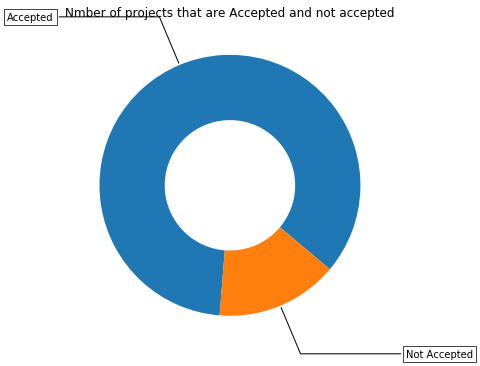

In [14]:
# PROVIDE CITATIONS TO YOUR CODE IF YOU TAKE IT FROM ANOTHER WEBSITE.
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py


y_value_counts = project_data['project_is_approved'].value_counts()

print("Number of projects thar are approved for funding ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of projects thar are not approved for funding ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Accepted", "Not Accepted"]

data = [y_value_counts[1], y_value_counts[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Nmber of projects that are Accepted and not accepted")

plt.show()

## 4. Data Preprocessing

### 4.1 Categorical data

#### 1. School State

In [15]:
from collections import Counter #counter is used to calculate how many time each category existed
my_counter = Counter()
for word in project_data['school_state'].values:
    my_counter.update(word.split())


In [16]:
state_dict = dict(my_counter)
sorted_state_dict = dict(sorted(state_dict.items(), key=lambda kv: kv[1])) # sort categories in desc order as a dictionary



#### 2. Teacher Prefix

In [17]:
project_data['teacher_prefix'].fillna("", inplace = True)
teacher_prefix = list(project_data['teacher_prefix'].values)

teacher_prefix_list = []
for i in teacher_prefix:
    temp = ""
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
         # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace('.','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    teacher_prefix_list.append(temp.strip())


In [18]:
project_data['clean_teacher_prefix'] = teacher_prefix_list
project_data.drop(['teacher_prefix'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id school_state  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           IN   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a           FL   

  project_submitted_datetime project_grade_category  \
0        2016-12-05 13:43:57          Grades PreK-2   
1        2016-10-25 09:22:10             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                             0                    0  154.6   
1                                             7                    1  299.0   

   quantity clean_teacher_prefix  
0        23                  Mrs  
1         1                   Mr

In [19]:
#project_data['teacher_prefix'].fillna(" ", inplace = True)
from collections import Counter
my_counter = Counter()
for word in project_data['clean_teacher_prefix'].values:
        my_counter.update(word.split())

In [20]:
teacher_prefix_dict = dict(my_counter)
sorted_teacher_prefix_dict = dict(sorted(teacher_prefix_dict.items(), key=lambda kv: kv[1]))

#### 3. project_grade_category

In [21]:
grades_cat = list(project_data['project_grade_category'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
grades_cat_list = []
for i in grades_cat:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
         # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    grades_cat_list.append(temp.strip())

In [22]:
project_data['clean_grades_categories'] = grades_cat_list
project_data.drop(['project_grade_category'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id school_state  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           IN   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a           FL   

  project_submitted_datetime         project_subject_categories  \
0        2016-12-05 13:43:57                Literacy & Language   
1        2016-10-25 09:22:10  History & Civics, Health & Sports   

      project_subject_subcategories  \
0                     ESL, Literacy   
1  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                             0                    0  154.6   
1                                             7                    1  299.0   

   quantity clean_teacher_prefix clean_grades_categories  
0        23                  Mrs            GradesPreK-2  
1         1                   Mr               Grades6-8

In [23]:
from collections import Counter
my_counter = Counter()
for word in project_data['clean_grades_categories'].values:
        my_counter.update(word.split())

In [24]:
project_grade_category_dict = dict(my_counter)
sorted_project_grade_category_dict = dict(sorted(project_grade_category_dict.items(), key=lambda kv: kv[1]))


#### 4. project_subject_categories

In [25]:

catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

In [26]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id school_state  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           IN   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a           FL   

  project_submitted_datetime     project_subject_subcategories  \
0        2016-12-05 13:43:57                     ESL, Literacy   
1        2016-10-25 09:22:10  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                             0                    0  154.6   
1                                             7                    1  299.0   

   quantity clean_teacher_prefix clean_grades_categories  \
0        23                  Mrs            GradesPreK-2   
1         1                   Mr               Grades6-8   

               clean_categories  
0             Literacy_Language  
1  History_Civics Health_Sports

In [27]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
# replacing na values in college with No college 
from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

In [28]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))



#### 5. project_subject_subcategories

In [29]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [30]:
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id school_state  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           IN   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a           FL   

  project_submitted_datetime  \
0        2016-12-05 13:43:57   
1        2016-10-25 09:22:10   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                             0                    0  154.6   
1                                             7                    1  299.0   

   quantity clean_teacher_prefix clean_grades_categories  \
0        23                  Mrs            GradesPreK-2   
1         1                   Mr               Grades6-8   

               clean_categories           clean_subcategories  
0             Literacy_Language                  ESL Literacy  
1  History_Civics Health_Sports  Civics_Government TeamSports

In [31]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())

In [32]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))


#### 6. presence_of_numerical_digits

In [33]:
#https://stackoverflow.com/questions/19859282/check-if-a-string-contains-a-number
def hasNumbers(inputString):
      
    if (any(char.isdigit() for char in inputString)):

        return 'yes'

    else:
        return 'No'
      

presence_of_numerical_digits=project_data['project_resource_summary'].map(hasNumbers)

In [34]:
#Add a new column to projects table
project_data['presence_of_numerical_digits'] = presence_of_numerical_digits


In [35]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['presence_of_numerical_digits'].values:
    my_counter.update(word.split())

In [36]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
presence_of_numerical_digits_dict = dict(my_counter)
sorted_presence_of_numerical_digits_dict = dict(sorted(presence_of_numerical_digits_dict.items(), key=lambda kv: kv[1]))


### 4.2 Text data

In [37]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [38]:
project_data.drop(['project_essay_1','project_essay_2','project_essay_3','project_essay_4'], axis=1, inplace=True)
project_data.head(2)


Unnamed: 0       id                        teacher_id school_state  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           IN   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a           FL   

  project_submitted_datetime  \
0        2016-12-05 13:43:57   
1        2016-10-25 09:22:10   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                            project_resource_summary  \
0  My students need opportunities to practice beg...   
1  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                             0                    0  154.6   
1                                             7                    1  299.0   

   quantity clean_teacher_prefix clean_grades_categories  \
0        23                  Mrs            GradesPreK-2   
1         1                   Mr               Grades6-8   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

  presence_of_numerical_digits  \
0                           No   
1                           No   

                                               essay  
0  My students are English learners that are work...  
1  Our students arrive to our school eager to lea...

In [39]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [40]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

#### 1. Essay

In [41]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in project_data['essay'].values:
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

In [42]:
project_data['clean_essay'] = preprocessed_essays
project_data.drop(['essay'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id school_state  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           IN   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a           FL   

  project_submitted_datetime  \
0        2016-12-05 13:43:57   
1        2016-10-25 09:22:10   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                            project_resource_summary  \
0  My students need opportunities to practice beg...   
1  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                             0                    0  154.6   
1                                             7                    1  299.0   

   quantity clean_teacher_prefix clean_grades_categories  \
0        23                  Mrs            GradesPreK-2   
1         1                   Mr               Grades6-8   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

  presence_of_numerical_digits  \
0                           No   
1                           No   

                                         clean_essay  
0  my students english learners working english s...  
1  our students arrive school eager learn they po...

#### 2. Project title

In [43]:
from tqdm import tqdm
preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_title.append(sent.lower().strip())

100%|███████████████████████████████| 109141/109141 [00:02<00:00, 39570.25it/s]


In [44]:
project_data['clean_project_title'] = preprocessed_title
project_data.drop(['project_title'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id school_state  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           IN   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a           FL   

  project_submitted_datetime  \
0        2016-12-05 13:43:57   
1        2016-10-25 09:22:10   

                            project_resource_summary  \
0  My students need opportunities to practice beg...   
1  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                             0                    0  154.6   
1                                             7                    1  299.0   

   quantity clean_teacher_prefix clean_grades_categories  \
0        23                  Mrs            GradesPreK-2   
1         1                   Mr               Grades6-8   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

  presence_of_numerical_digits  \
0                           No   
1                           No   

                                         clean_essay  \
0  my students english learners working english s...   
1  our students arrive school eager learn they po...   

                         clean_project_title  
0  educational support english learners home  
1           wanted projector hungry learners

#### 3. Project_resource_summary

In [45]:
from tqdm import tqdm
preprocessed_project_resource_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_resource_summary'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_project_resource_summary.append(sent.lower().strip())

100%|███████████████████████████████| 109141/109141 [00:06<00:00, 17033.68it/s]


In [46]:
project_data['clean_project_resource_summary'] = preprocessed_project_resource_summary
project_data.drop(['project_resource_summary'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id school_state  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           IN   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a           FL   

  project_submitted_datetime  teacher_number_of_previously_posted_projects  \
0        2016-12-05 13:43:57                                             0   
1        2016-10-25 09:22:10                                             7   

   project_is_approved  price  quantity clean_teacher_prefix  \
0                    0  154.6        23                  Mrs   
1                    1  299.0         1                   Mr   

  clean_grades_categories              clean_categories  \
0            GradesPreK-2             Literacy_Language   
1               Grades6-8  History_Civics Health_Sports   

            clean_subcategories presence_of_numerical_digits  \
0                  ESL Literacy                           No   
1  Civics_Government TeamSports                           No   

                                         clean_essay  \
0  my students english learners working english s...   
1  our students arrive school eager learn they po...   

                         clean_project_title  \
0  educational support english learners home   
1           wanted projector hungry learners   

                      clean_project_resource_summary  
0  my students need opportunities practice beginn...  
1  my students need projector help viewing educat...

In [47]:
project_data.shape

(109141, 17)

# 5. Splitting the Data

In [48]:
y = project_data['project_is_approved']
project_data.drop(['project_is_approved'], axis=1, inplace=True)
X=project_data
print(X.shape)
print(y.shape)


(109141, 16)
(109141,)


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection

I am splitting only in Train and test because GridSearch CV will take care of 3-fold cross validation from the training dataset itself and we will end up using more data as training data

In [50]:
#Split the data into train and test

X_tr, X_test, y_tr, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0)

In [51]:
print(X_tr.shape)
print(y_tr.shape)
print(X_test.shape)
print(y_test.shape)

(76398, 16)
(76398,)
(32743, 16)
(32743,)


# 6. Vectorising text, categorical and numerical features
Fitting of the vectorizer will only be done on the training data and using the parameters of the fit we will transform both training data and test data. This will avoid data leakage.

### 6.1 Text features Vectorisation

#### BOW

In [52]:
feature_name_bow=list()

#### 1.Essay

In [53]:
vectorizer_essay_bow = CountVectorizer(min_df=10,max_features=5000)
vectorizer_essay_bow.fit(X_tr['clean_essay'].values) # fit has to happen only on train data
X_tr_essay_bow = vectorizer_essay_bow.transform(X_tr['clean_essay'].values)
X_test_essay_bow = vectorizer_essay_bow.transform(X_test['clean_essay'].values)
print("The shape of matrix after vectorisation")
print(X_tr_essay_bow.shape, y_tr.shape)
print(X_test_essay_bow.shape, y_test.shape)
for a in vectorizer_essay_bow.get_feature_names() :
    feature_name_bow.append(a)

The shape of matrix after vectorisation
(76398, 5000) (76398,)
(32743, 5000) (32743,)


#### 2.Project Title

In [54]:
vectorizer_project_title_bow = CountVectorizer(min_df=10,max_features=5000)
vectorizer_project_title_bow.fit(X_tr['clean_project_title'].values) # fit has to happen only on train data
X_tr_project_title_bow = vectorizer_project_title_bow.transform(X_tr['clean_project_title'].values)
X_test_project_title_bow = vectorizer_project_title_bow.transform(X_test['clean_project_title'].values)
print("The shape of matrix after vectorisation")
print(X_tr_project_title_bow.shape, y_tr.shape)
print(X_test_project_title_bow.shape, y_test.shape)
for a in vectorizer_project_title_bow.get_feature_names() :
    feature_name_bow.append(a)

The shape of matrix after vectorisation
(76398, 2689) (76398,)
(32743, 2689) (32743,)


#### 2.Project Resource Summary

In [55]:
vectorizer = CountVectorizer(min_df=10,max_features=5000)
vectorizer.fit(X_tr['clean_project_resource_summary'].values) # fit has to happen only on train data
X_tr_clean_project_resource_summary_bow = vectorizer.transform(X_tr['clean_project_resource_summary'].values)
X_test_clean_project_resource_summary_bow = vectorizer.transform(X_test['clean_project_resource_summary'].values)
print("The shape of matrix after vectorisation")
print(X_tr_clean_project_resource_summary_bow.shape, y_tr.shape)
print(X_test_clean_project_resource_summary_bow.shape, y_test.shape)

The shape of matrix after vectorisation
(76398, 4942) (76398,)
(32743, 4942) (32743,)


#### TFIDF

In [56]:
feature_name_tfidf=list()

#### 1.Essay

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [58]:
vectorizer_essay_tfidf = TfidfVectorizer(min_df=10,max_features=5000)
vectorizer_essay_tfidf.fit(X_tr['clean_essay'].values) # fit has to happen only on train data
X_tr_essay_tfidf = vectorizer_essay_tfidf.transform(X_tr['clean_essay'].values)
X_test_essay_tfidf = vectorizer_essay_tfidf.transform(X_test['clean_essay'].values)
print("The shape of matrix after vectorisation")
print(X_tr_essay_tfidf.shape, y_tr.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

for a in vectorizer_essay_tfidf.get_feature_names() :
    feature_name_tfidf.append(a)


The shape of matrix after vectorisation
(76398, 5000) (76398,)
(32743, 5000) (32743,)


#### 2. Project Title

In [59]:
vectorizer_project_title_tfidf = CountVectorizer(min_df=10,max_features=5000)
vectorizer_project_title_tfidf.fit(X_tr['clean_project_title'].values) # fit has to happen only on train data
X_tr_project_title_tfidf = vectorizer_project_title_tfidf.transform(X_tr['clean_project_title'].values)
X_test_project_title_tfidf = vectorizer_project_title_tfidf.transform(X_test['clean_project_title'].values)
print("The shape of matrix after vectorisation")
print(X_tr_project_title_tfidf.shape, y_tr.shape)
print(X_test_project_title_tfidf.shape, y_test.shape)

for a in vectorizer_project_title_tfidf.get_feature_names() :
    feature_name_tfidf.append(a)
    

The shape of matrix after vectorisation
(76398, 2689) (76398,)
(32743, 2689) (32743,)


#### 3. Project Resource Summary

In [60]:
vectorizer = CountVectorizer(min_df=10,max_features=5000)
vectorizer.fit(X_tr['clean_project_resource_summary'].values) # fit has to happen only on train data
X_tr_clean_project_resource_summary_tfidf = vectorizer.transform(X_tr['clean_project_resource_summary'].values)
X_test_clean_project_resource_summary_tfidf = vectorizer.transform(X_test['clean_project_resource_summary'].values)
print("The shape of matrix after vectorisation")
print(X_tr_clean_project_resource_summary_tfidf.shape, y_tr.shape)
print(X_test_clean_project_resource_summary_tfidf.shape, y_test.shape)

The shape of matrix after vectorisation
(76398, 4942) (76398,)
(32743, 4942) (32743,)


#### avg word2vec 

In [61]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

####  1.Text

In [62]:
# average Word2Vec
# compute average word2vec for each review.
Tr_avg_w2v_vectors_essay = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_tr['clean_essay'].values): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word][:50]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    Tr_avg_w2v_vectors_essay.append(vector)
print("Training data")
print(len(Tr_avg_w2v_vectors_essay))
print(len(Tr_avg_w2v_vectors_essay[0]))


Test_avg_w2v_vectors_essay = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['clean_essay'].values): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word][:50]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    Test_avg_w2v_vectors_essay.append(vector)
    
print("Test data")
print(len(Test_avg_w2v_vectors_essay))
print(len(Test_avg_w2v_vectors_essay[0]))

100%|██████████████████████████████████| 76398/76398 [00:20<00:00, 3706.81it/s]


Training data
76398
50


100%|██████████████████████████████████| 32743/32743 [00:08<00:00, 3712.57it/s]


Test data
32743
50


####  2.Project Title

In [63]:
# average Word2Vec
# compute average word2vec for each review.
Tr_avg_w2v_vectors_project_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_tr['clean_project_title'].values): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word][:50]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    Tr_avg_w2v_vectors_project_title.append(vector)
print("Training data")
print(len(Tr_avg_w2v_vectors_project_title))
print(len(Tr_avg_w2v_vectors_project_title[0]))



Test_avg_w2v_vectors_project_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['clean_project_title'].values): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word][:50]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    Test_avg_w2v_vectors_project_title.append(vector)
    
print("Test data")
print(len(Test_avg_w2v_vectors_project_title))
print(len(Test_avg_w2v_vectors_project_title[0]))

100%|█████████████████████████████████| 76398/76398 [00:00<00:00, 83036.54it/s]


Training data
76398
50


100%|█████████████████████████████████| 32743/32743 [00:00<00:00, 81445.62it/s]


Test data
32743
50


####  3.Project Resource Summary

In [64]:
# average Word2Vec
# compute average word2vec for each review.
Tr_avg_w2v_vectors_project_resource_summary = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_tr['clean_project_resource_summary'].values): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word][:50]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    Tr_avg_w2v_vectors_project_resource_summary.append(vector)
print("Training data")
print(len(Tr_avg_w2v_vectors_project_resource_summary))
print(len(Tr_avg_w2v_vectors_project_resource_summary[0]))



Test_avg_w2v_vectors_project_resource_summary = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['clean_project_resource_summary'].values): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word][:50]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    Test_avg_w2v_vectors_project_resource_summary.append(vector)
    
print("Test data")
print(len(Test_avg_w2v_vectors_project_resource_summary))
print(len(Test_avg_w2v_vectors_project_resource_summary[0]))

100%|█████████████████████████████████| 76398/76398 [00:02<00:00, 35269.45it/s]


Training data
76398
50


100%|█████████████████████████████████| 32743/32743 [00:00<00:00, 34979.84it/s]


Test data
32743
50


#### tfidf word2vec

In [65]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_tr['clean_essay'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

####  1.Text

In [66]:
tr_tfidf_w2v_vectors_essay = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_tr['clean_essay'].values): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word][:50] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tr_tfidf_w2v_vectors_essay.append(vector)
    
print("Training data")
print(len(tr_tfidf_w2v_vectors_essay))
print(len(tr_tfidf_w2v_vectors_essay[0]))



Test_tfidf_w2v_vectors_essay = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['clean_essay'].values): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word][:50] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    Test_tfidf_w2v_vectors_essay.append(vector)
    
print("Test data")
print(len(Test_tfidf_w2v_vectors_essay))
print(len(Test_tfidf_w2v_vectors_essay[0]))

100%|███████████████████████████████████| 76398/76398 [02:32<00:00, 499.95it/s]


Training data
76398
50


100%|███████████████████████████████████| 32743/32743 [01:05<00:00, 500.76it/s]


Test data
32743
50


####  2.Project Title

In [67]:
tr_tfidf_w2v_vectors_project_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_tr['clean_project_title'].values): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word][:50] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tr_tfidf_w2v_vectors_project_title.append(vector)
    
print("Training data")
print(len(tr_tfidf_w2v_vectors_project_title))
print(len(tr_tfidf_w2v_vectors_project_title[0]))


Test_tfidf_w2v_vectors_project_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['clean_project_title'].values): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word][:50] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    Test_tfidf_w2v_vectors_project_title.append(vector)
    
print("Test data")
print(len(Test_tfidf_w2v_vectors_project_title))
print(len(Test_tfidf_w2v_vectors_project_title[0]))

100%|█████████████████████████████████| 76398/76398 [00:02<00:00, 36976.59it/s]


Training data
76398
50


100%|█████████████████████████████████| 32743/32743 [00:00<00:00, 37121.46it/s]


Test data
32743
50


#### 3. Project Resource Summary

In [68]:
tr_tfidf_w2v_vectors_project_resource_summary = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_tr['clean_project_resource_summary'].values): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word][:50] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tr_tfidf_w2v_vectors_project_resource_summary.append(vector)
    
print("Training data")
print(len(tr_tfidf_w2v_vectors_project_resource_summary))
print(len(tr_tfidf_w2v_vectors_project_resource_summary[0]))


Test_tfidf_w2v_vectors_project_resource_summary = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['clean_project_resource_summary'].values): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word][:50] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    Test_tfidf_w2v_vectors_project_resource_summary.append(vector)
    
print("Test data")
print(len(Test_tfidf_w2v_vectors_project_resource_summary))
print(len(Test_tfidf_w2v_vectors_project_resource_summary[0]))

100%|█████████████████████████████████| 76398/76398 [00:06<00:00, 12363.43it/s]


Training data
76398
50


100%|█████████████████████████████████| 32743/32743 [00:02<00:00, 12458.57it/s]


Test data
32743
50


### 6.2 Categorical features Vectorisation

#### 1. School State

In [69]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_school_state = CountVectorizer(vocabulary=list(sorted_state_dict.keys()), lowercase=False, binary=True)
vectorizer_school_state.fit(X_tr['school_state'].values)
print(vectorizer_school_state.get_feature_names())


Tr_state_one_hot = vectorizer_school_state.transform(X_tr['school_state'].values)
Test_state_one_hot = vectorizer_school_state.transform(X_test['school_state'].values)

print("Shape of matrix after one hot encoding")
print(Tr_state_one_hot.shape)
print(Test_state_one_hot.shape)

for a in vectorizer_school_state.get_feature_names() :
    feature_name_bow.append(a)
    
for a in vectorizer_school_state.get_feature_names() :
    feature_name_tfidf.append(a)
    

['VT', 'WY', 'ND', 'MT', 'RI', 'SD', 'NE', 'DE', 'AK', 'NH', 'WV', 'ME', 'HI', 'DC', 'NM', 'KS', 'IA', 'ID', 'AR', 'CO', 'MN', 'OR', 'KY', 'MS', 'NV', 'MD', 'CT', 'TN', 'UT', 'AL', 'WI', 'VA', 'AZ', 'NJ', 'OK', 'WA', 'MA', 'LA', 'OH', 'MO', 'IN', 'PA', 'MI', 'SC', 'GA', 'IL', 'NC', 'FL', 'NY', 'TX', 'CA']
Shape of matrix after one hot encoding
(76398, 51)
(32743, 51)


#### 2. Teacher Prefix

In [70]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_teacher_prefix = CountVectorizer(vocabulary=list(sorted_teacher_prefix_dict.keys()), lowercase=False, binary=True)
vectorizer_teacher_prefix.fit(X_tr['clean_teacher_prefix'].values)
print(vectorizer_teacher_prefix.get_feature_names())


Tr_clean_teacher_prefix_one_hot = vectorizer_teacher_prefix.transform(X_tr['clean_teacher_prefix'].values)
Test_clean_teacher_prefix_one_hot = vectorizer_teacher_prefix.transform(X_test['clean_teacher_prefix'].values)

print("Shape of matrix after one hot encoding")
print(Tr_clean_teacher_prefix_one_hot.shape)
print(Test_clean_teacher_prefix_one_hot.shape)

for a in vectorizer_teacher_prefix.get_feature_names() :
    feature_name_bow.append(a)
    
for a in vectorizer_teacher_prefix.get_feature_names() :
    feature_name_tfidf.append(a)

['Dr', 'Teacher', 'Mr', 'Ms', 'Mrs']
Shape of matrix after one hot encoding
(76398, 5)
(32743, 5)


#### 3. Grades Cateogory

In [71]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_grades_caterories = CountVectorizer(vocabulary=list(sorted_project_grade_category_dict.keys()), lowercase=False, binary=True)
vectorizer_grades_caterories.fit(X_tr['clean_teacher_prefix'].values)
print(vectorizer_grades_caterories.get_feature_names())


Tr_clean_grades_categories_one_hot = vectorizer_grades_caterories.transform(X_tr['clean_grades_categories'].values)
Test_clean_grades_categories_one_hot = vectorizer_grades_caterories.transform(X_test['clean_grades_categories'].values)

print("Shape of matrix after one hot encoding")
print(Tr_clean_grades_categories_one_hot.shape)
print(Test_clean_grades_categories_one_hot.shape)


for a in vectorizer_grades_caterories.get_feature_names() :
    feature_name_bow.append(a)
    
for a in vectorizer_grades_caterories.get_feature_names() :
    feature_name_tfidf.append(a)

['Grades9-12', 'Grades6-8', 'Grades3-5', 'GradesPreK-2']
Shape of matrix after one hot encoding
(76398, 4)
(32743, 4)


#### 4. Subject Categories

In [72]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_caterories = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_caterories.fit(X_tr['clean_categories'].values)
print(vectorizer_caterories.get_feature_names())


Tr_clean_categories_one_hot = vectorizer_caterories.transform(X_tr['clean_categories'].values)
Test_clean_categories_one_hot = vectorizer_caterories.transform(X_test['clean_categories'].values)

print("Shape of matrix after one hot encoding")
print(Tr_clean_categories_one_hot.shape)
print(Test_clean_categories_one_hot.shape)

for a in vectorizer_caterories.get_feature_names() :
    feature_name_bow.append(a)
    
for a in vectorizer_caterories.get_feature_names() :
    feature_name_tfidf.append(a)  

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix after one hot encoding
(76398, 9)
(32743, 9)


#### 5. Subject SubCategories

In [73]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_subcaterories = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_subcaterories.fit(X_tr['clean_subcategories'].values)
print(vectorizer_subcaterories.get_feature_names())


Tr_clean_subcategories_one_hot = vectorizer_subcaterories.transform(X_tr['clean_subcategories'].values)
Test_clean_subcategories_one_hot = vectorizer_subcaterories.transform(X_test['clean_subcategories'].values)

print("Shape of matrix after one hot encoding")
print(Tr_clean_subcategories_one_hot.shape)
print(Test_clean_subcategories_one_hot.shape)


for a in vectorizer_subcaterories.get_feature_names() :
    feature_name_bow.append(a)
    
for a in vectorizer_subcaterories.get_feature_names() :
    feature_name_tfidf.append(a)
    
print(len(feature_name_tfidf))

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encoding
(76398, 30)
(32743, 30)
7788


#### 6. Presence of Numerical digit in resource summary

In [74]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_presence_of_numerical_digits = CountVectorizer(vocabulary=list(sorted_presence_of_numerical_digits_dict.keys()), lowercase=False, binary=True)
vectorizer_presence_of_numerical_digits.fit(X_tr['presence_of_numerical_digits'].values)
print(vectorizer_presence_of_numerical_digits.get_feature_names())


Tr_presence_of_numerical_digits_one_hot = vectorizer_presence_of_numerical_digits.transform(X_tr['presence_of_numerical_digits'].values)
Test_presence_of_numerical_digits_one_hot = vectorizer_presence_of_numerical_digits.transform(X_test['presence_of_numerical_digits'].values)

print("Shape of matrix after one hot encoding")
print(Tr_presence_of_numerical_digits_one_hot.shape)
print(Test_presence_of_numerical_digits_one_hot.shape)

for a in vectorizer_presence_of_numerical_digits.get_feature_names() :
    feature_name_bow.append(a)
    
for a in vectorizer_presence_of_numerical_digits.get_feature_names() :
    feature_name_tfidf.append(a)

['yes', 'No']
Shape of matrix after one hot encoding
(76398, 2)
(32743, 2)


### 6.3 Numerical features Vectorisation

#### 1.Price

In [75]:
from sklearn.preprocessing import StandardScaler
b= list()
price_scalar = StandardScaler()
price_scalar.fit(X_tr['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
Tr_price_standardized = price_scalar.transform(X_tr['price'].values.reshape(-1, 1))
Test_price_standardized = price_scalar.transform(X_test['price'].values.reshape(-1, 1))

print("Shape of matrix after standarsation")
print(Tr_price_standardized.shape)
print(Test_price_standardized.shape)

feature_name_bow.append("price")
feature_name_tfidf.append("price")

Mean : 298.4207332652687, Standard deviation : 370.0163510413358
Shape of matrix after standarsation
(76398, 1)
(32743, 1)


#### 2. Teacher number of previously posted scalars

In [76]:
teacher_number_of_previously_posted_projects_scalar = StandardScaler()
teacher_number_of_previously_posted_projects_scalar.fit(X_tr['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {teacher_number_of_previously_posted_projects_scalar.mean_[0]}, Standard deviation : {np.sqrt(teacher_number_of_previously_posted_projects_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
Tr_teacher_number_of_previously_posted_projects_standardized = teacher_number_of_previously_posted_projects_scalar.transform(X_tr['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
Test_teacher_number_of_previously_posted_projects_standardized = teacher_number_of_previously_posted_projects_scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

print("Shape of matrix after standarsation")
print(Tr_teacher_number_of_previously_posted_projects_standardized.shape)
print(Test_teacher_number_of_previously_posted_projects_standardized.shape)

feature_name_bow.append("teacher_number_of_previously_posted_projects")
feature_name_tfidf.append("teacher_number_of_previously_posted_projects")

E:\Programs\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



Mean : 11.031558417759626, Standard deviation : 27.35184440105008


E:\Programs\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

E:\Programs\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



Shape of matrix after standarsation
(76398, 1)
(32743, 1)


#### 3. Quantity

In [77]:
quantity_scalar = StandardScaler()
quantity_scalar.fit(X_tr['quantity'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {quantity_scalar.mean_[0]}, Standard deviation : {np.sqrt(quantity_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
Tr_quantity_standardized = quantity_scalar.transform(X_tr['quantity'].values.reshape(-1, 1))
Test_quantity_standardized = quantity_scalar.transform(X_test['quantity'].values.reshape(-1, 1))

print("Shape of matrix after standarsation")
print(Tr_quantity_standardized.shape)
print(Test_quantity_standardized.shape)

feature_name_bow.append("Quantity")
feature_name_tfidf.append("Quantity")

E:\Programs\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



Mean : 17.03942511584073, Standard deviation : 25.904357242036095


E:\Programs\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

E:\Programs\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



Shape of matrix after standarsation
(76398, 1)
(32743, 1)


## 7. Apply Decision Tree

####  Set 1: categorical, numerical features + project_title(BOW) + preprocessed_eassay (BOW)

In [78]:
from scipy.sparse import hstack
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import pylab
##https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

In [79]:
# First combine all features to create total matrix
X_tr_LR_BOW = hstack((X_tr_essay_bow,X_tr_project_title_bow,Tr_state_one_hot,Tr_clean_teacher_prefix_one_hot,
                      Tr_clean_grades_categories_one_hot,Tr_clean_categories_one_hot,Tr_clean_subcategories_one_hot,
                      Tr_presence_of_numerical_digits_one_hot,
                      Tr_price_standardized, Tr_teacher_number_of_previously_posted_projects_standardized,
                      Tr_quantity_standardized   
                     ))

X_test_LR_BOW = hstack((X_test_essay_bow,X_test_project_title_bow,Test_state_one_hot,Test_clean_teacher_prefix_one_hot,
                      Test_clean_grades_categories_one_hot,Test_clean_categories_one_hot,Test_clean_subcategories_one_hot,
                      Test_presence_of_numerical_digits_one_hot,
                      Test_price_standardized, Test_teacher_number_of_previously_posted_projects_standardized,
                      Test_quantity_standardized   
                     ))
print(X_tr_LR_BOW.shape)
print(X_test_LR_BOW.shape)

(76398, 7793)
(32743, 7793)


{'max_depth': 10, 'min_samples_split': 500}
0.6730367627338749


E:\Programs\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning:

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.



Text(0.5, 12.0, 'min_samples_split')

E:\Programs\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning:

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.



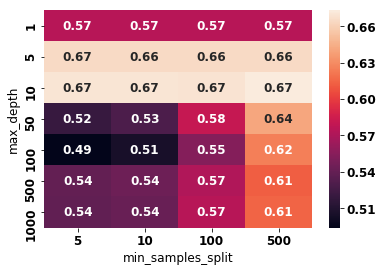

In [80]:
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV 

param_grid = {'max_depth':[ 1, 5, 10, 50, 100, 500, 1000],
              'min_samples_split':[5, 10, 100, 500]}

#Hyper parameter Tuning for lamda with 3 fold cross validation
clf = DecisionTreeClassifier()

clf_cv= GridSearchCV(clf,param_grid,cv=2,scoring='roc_auc')

clf_cv.fit(X_tr_LR_BOW.toarray(),y_tr)

print(clf_cv.best_params_)

print(clf_cv.best_score_)

#https://www.kaggle.com/jinilcs/grid-search-to-find-best-tuning-parameters
results_df = pd.DataFrame(clf_cv.cv_results_)

scores = np.array(results_df.mean_test_score).reshape(7, 4)

sns.heatmap(scores, annot=True, 
            yticklabels=param_grid['max_depth'], xticklabels=param_grid['min_samples_split'])
plt.ylabel('max_depth')
plt.xlabel('min_samples_split')


E:\Programs\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning:

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.



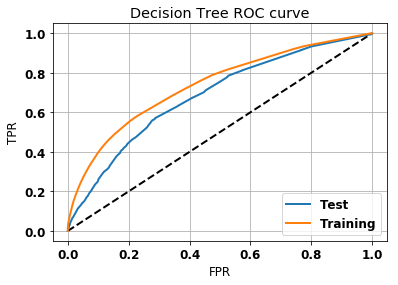

The Training AUC (area under curve) for hypertuned parameter maximum depth=10 and min_samples_split =500 = 0.7362523843308941
The Test AUC (area under curve) for hypertuned parameter maximum depth=10 and min_samples_split =500 = 0.6825737208929942


In [81]:
#Instantiate Classifier
clf = DecisionTreeClassifier(class_weight='balanced',max_depth=clf_cv.best_params_.get('max_depth'),min_samples_split=clf_cv.best_params_.get('min_samples_split'))
clf.fit(X_tr_LR_BOW.toarray(),y_tr)
y_pred_proba_test = clf.predict_proba(X_test_LR_BOW.toarray())[:,1]
y_pred_proba_tr = clf.predict_proba(X_tr_LR_BOW.toarray())[:,1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_proba_test)
fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_tr, y_pred_proba_tr)
plt.plot([0,1],[0,1],'k--',linewidth=2.0)
plt.plot(fpr_test,tpr_test, label='Test',linewidth=2.0)
plt.plot(fpr_tr,tpr_tr, label='Training',linewidth=2.0)
plt.xlabel('FPR')
plt.ylabel('TPR')
pylab.legend(loc='lower right')
plt.title('Decision Tree ROC curve')
plt.grid()
plt.show()
#Area under ROC curve
print('The Training AUC (area under curve) for hypertuned parameter maximum depth={} and min_samples_split ={} = {}'.format(clf_cv.best_params_.get('max_depth'),clf_cv.best_params_.get('min_samples_split'),roc_auc_score(y_tr,y_pred_proba_tr)))
print('The Test AUC (area under curve) for hypertuned parameter maximum depth={} and min_samples_split ={} = {}'.format(clf_cv.best_params_.get('max_depth'),clf_cv.best_params_.get('min_samples_split'),roc_auc_score(y_test,y_pred_proba_test)))

test_AUC_BOW = roc_auc_score(y_test,y_pred_proba_test)
training_AUC_BOW = roc_auc_score(y_tr,y_pred_proba_tr)
depth_BOW = clf_cv.best_params_.get('max_depth')
split_BOW = clf_cv.best_params_.get('min_samples_split')


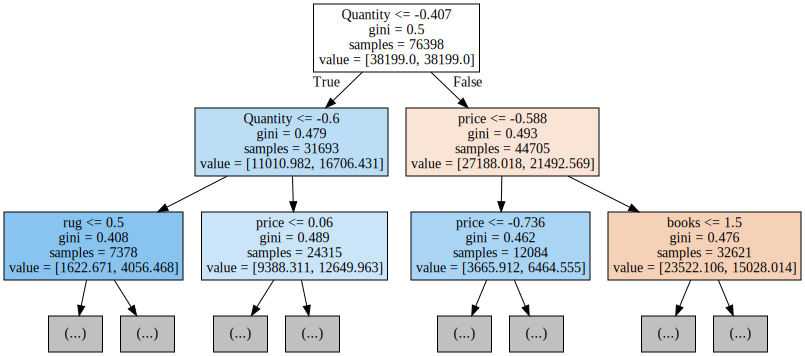

In [82]:
from graphviz import Digraph
import os
os.environ["PATH"] += os.pathsep + 'J:/Program Files (x86)/Graphviz2.38/bin/'

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

graph = Source(tree.export_graphviz(clf, out_file=None, max_depth=2, filled = True,feature_names=feature_name_bow))
display(SVG(graph.pipe(format='svg')))

#### Finding optimum threshold value

Finding optimum threshold using training data for high tpr and low fpr. For this we use maximum value of parameter tr=tpr*(1-fpr)

In [83]:
#https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
i = np.arange(0,len(tpr_tr)) 
roc = pd.DataFrame({'fpr' : pd.Series(fpr_tr, index=i),'tpr' : pd.Series(tpr_tr, index = i), '1-fpr' : pd.Series(1-fpr_tr, index = i), 'tf' : pd.Series(tpr_tr*(1-fpr_tr), index = i), 'thresholds' : pd.Series(thresholds_tr, index = i)})
roc.ix[(roc.tf-0).abs().argsort()[:1]]

index=roc['tf'].idxmax()

optimim_threshold=roc['thresholds'].iloc[index]
print(roc.iloc[index])
print(optimim_threshold)

fpr           0.292674
tpr           0.639471
1-fpr         0.707326
tf            0.452314
thresholds    0.473488
Name: 88, dtype: float64
0.47348802787445843


#### Confusion Matrix for training data (BOW)

We calculate the predicted value of class for training data using the threshold calculated using training data.

In [84]:
y_pred = (clf.predict_proba(X_tr_LR_BOW.toarray())[:,1] >= optimim_threshold)*1
cf=confusion_matrix(y_tr,y_pred)

Printing confusion matrix for training data

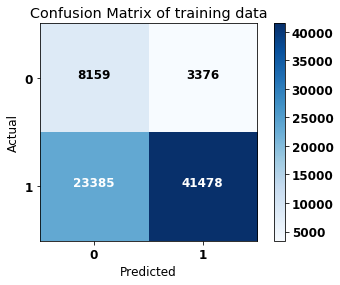

In [85]:
##https://www.kaggle.com/jprakashds/confusion-matrix-in-python-binary-class
import itertools
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix of training data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(y_test))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show();

As we have balanced the data, it can be seen in the confusion matrix that our model is not baised towards the majority class

#### Confusion Matrix for Test data (BOW)

We calculate the predicted value of class for test data using the threshold calculated using training data.

In [86]:
y_pred = (clf.predict_proba(X_test_LR_BOW.toarray())[:,1] >= optimim_threshold)*1
cf=confusion_matrix(y_test,y_pred)

Printing confusion matrix for test data

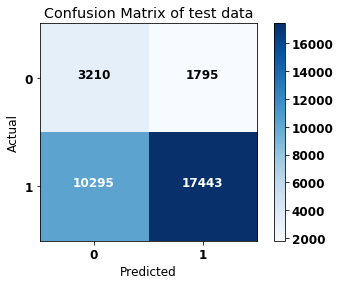

In [87]:
##https://www.kaggle.com/jprakashds/confusion-matrix-in-python-binary-class
import itertools
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix of test data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(y_test))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show();

## Wordcloud for False positive Essay

32743
1795


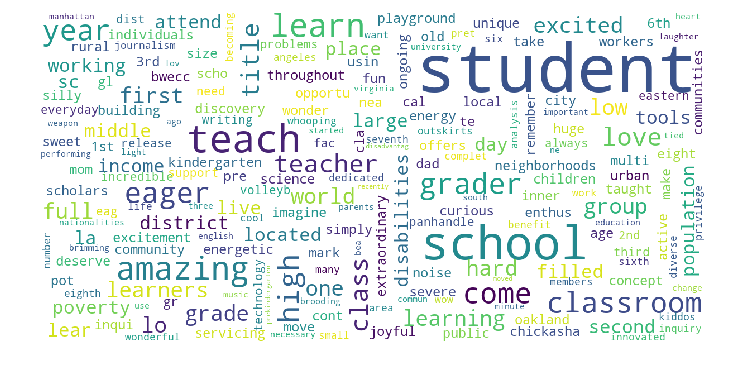

In [88]:
from wordcloud import WordCloud, STOPWORDS 

print(len(X_test))
# Saving all false positive test data
X_test_FP = X_test[(y_test == 0) & (y_pred == 1)]
print(len(X_test_FP))

stopwords = set(STOPWORDS)

#https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
  
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(X_test_FP['clean_essay'])
 

## Box Plot with for price of false positive data points

In [89]:
price_FP = X_test_FP['price'].values

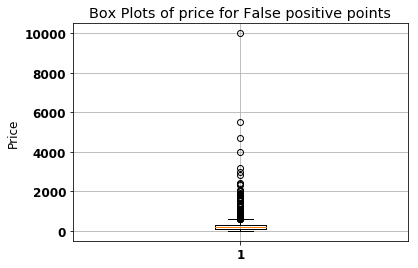

In [90]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot(price_FP)
plt.title('Box Plots of price for False positive points')
plt.ylabel('Price')
plt.grid()
plt.show()

## PDF with the teacher_number_of_previously_posted_projects of false positive data points

No handles with labels found to put in legend.


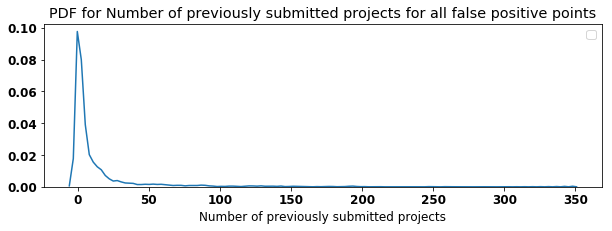

In [91]:
teacher_posted_projects_FP = X_test_FP['teacher_number_of_previously_posted_projects'].values
plt.figure(figsize=(10,3))
sns.distplot(teacher_posted_projects_FP, hist=False)
plt.title('PDF for Number of previously submitted projects for all false positive points')
plt.xlabel('Number of previously submitted projects')
plt.legend()
plt.show()

#### Set 2: categorical, numerical features + project_title(TFIDF)+ preprocessed_eassay (TFIDF)

In [92]:
# First combine all features to create total matrix
X_tr_LR_TFIDF = hstack((X_tr_essay_tfidf,X_tr_project_title_tfidf,Tr_state_one_hot,Tr_clean_teacher_prefix_one_hot,
                      Tr_clean_grades_categories_one_hot,Tr_clean_categories_one_hot,Tr_clean_subcategories_one_hot,
                      Tr_presence_of_numerical_digits_one_hot,
                      Tr_price_standardized, Tr_teacher_number_of_previously_posted_projects_standardized,
                      Tr_quantity_standardized   
                     ))

X_test_LR_TFIDF = hstack((X_test_essay_tfidf,X_test_project_title_tfidf,Test_state_one_hot,Test_clean_teacher_prefix_one_hot,
                      Test_clean_grades_categories_one_hot,Test_clean_categories_one_hot,Test_clean_subcategories_one_hot,
                      Test_presence_of_numerical_digits_one_hot,
                      Test_price_standardized, Test_teacher_number_of_previously_posted_projects_standardized,
                      Test_quantity_standardized   
                     ))
print(X_tr_LR_TFIDF.shape)
print(X_test_LR_TFIDF.shape)

(76398, 7793)
(32743, 7793)


{'max_depth': 10, 'min_samples_split': 500}
0.6689275659951186


Text(0.5, 12.0, 'min_samples_split')

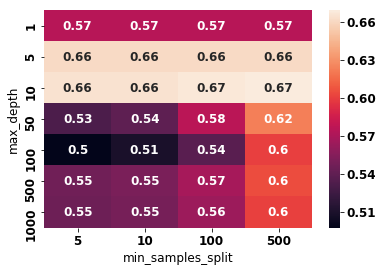

In [93]:
param_grid = {'max_depth':[ 1, 5, 10, 50, 100, 500, 1000],
              'min_samples_split':[5, 10, 100, 500]}

#Hyper parameter Tuning for lamda with 3 fold cross validation
clf = DecisionTreeClassifier()

clf_cv= GridSearchCV(clf,param_grid,cv=2,scoring='roc_auc')

clf_cv.fit(X_tr_LR_TFIDF.toarray(),y_tr)

print(clf_cv.best_params_)

print(clf_cv.best_score_)

#https://www.kaggle.com/jinilcs/grid-search-to-find-best-tuning-parameters
results_df = pd.DataFrame(clf_cv.cv_results_)

scores = np.array(results_df.mean_test_score).reshape(7, 4)

sns.heatmap(scores, annot=True, 
            yticklabels=param_grid['max_depth'], xticklabels=param_grid['min_samples_split'])
plt.ylabel('max_depth')
plt.xlabel('min_samples_split')


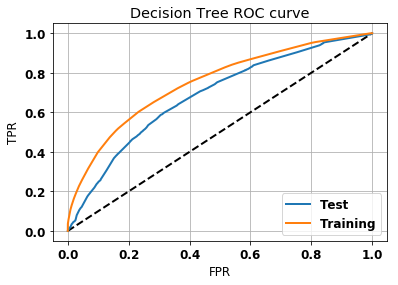

The Training AUC (area under curve) for hypertuned parameter maximum depth=10 and min_samples_split =500 = 0.7478566371303043
The Test AUC (area under curve) for hypertuned parameter maximum depth=10 and min_samples_split =500 = 0.6824250052348689


In [94]:
#Instantiate Classifier
clf = DecisionTreeClassifier(class_weight='balanced',max_depth=clf_cv.best_params_.get('max_depth'),min_samples_split=clf_cv.best_params_.get('min_samples_split'))
clf.fit(X_tr_LR_TFIDF.toarray(),y_tr)
y_pred_proba_test = clf.predict_proba(X_test_LR_TFIDF.toarray())[:,1]
y_pred_proba_tr = clf.predict_proba(X_tr_LR_TFIDF.toarray())[:,1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_proba_test)
fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_tr, y_pred_proba_tr)
plt.plot([0,1],[0,1],'k--',linewidth=2.0)
plt.plot(fpr_test,tpr_test, label='Test',linewidth=2.0)
plt.plot(fpr_tr,tpr_tr, label='Training',linewidth=2.0)
plt.xlabel('FPR')
plt.ylabel('TPR')
pylab.legend(loc='lower right')
plt.title('Decision Tree ROC curve')
plt.grid()
plt.show()
#Area under ROC curve
print('The Training AUC (area under curve) for hypertuned parameter maximum depth={} and min_samples_split ={} = {}'.format(clf_cv.best_params_.get('max_depth'),clf_cv.best_params_.get('min_samples_split'),roc_auc_score(y_tr,y_pred_proba_tr)))
print('The Test AUC (area under curve) for hypertuned parameter maximum depth={} and min_samples_split ={} = {}'.format(clf_cv.best_params_.get('max_depth'),clf_cv.best_params_.get('min_samples_split'),roc_auc_score(y_test,y_pred_proba_test)))

test_AUC_TFIDF = roc_auc_score(y_test,y_pred_proba_test)
training_AUC_TFIDF = roc_auc_score(y_tr,y_pred_proba_tr)
depth_TFIDF = clf_cv.best_params_.get('max_depth')
split_TFIDF = clf_cv.best_params_.get('min_samples_split')

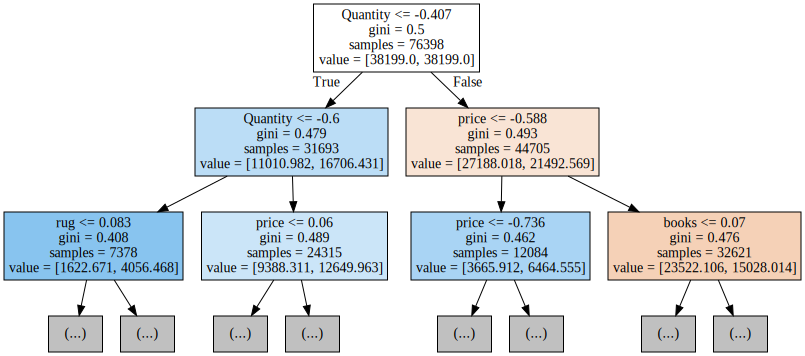

In [95]:
from graphviz import Digraph
import os
os.environ["PATH"] += os.pathsep + 'J:/Program Files (x86)/Graphviz2.38/bin/'

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

graph = Source(tree.export_graphviz(clf, out_file=None, max_depth=2, filled = True,feature_names=feature_name_tfidf))
display(SVG(graph.pipe(format='svg')))

#### Finding optimum threshold value

Finding optimum threshold using training data for high tpr and low fpr. For this we use maximum value of parameter tr=tpr*(1-fpr)

In [96]:
i = np.arange(0,len(tpr_tr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr_tr, index=i),'tpr' : pd.Series(tpr_tr, index = i), '1-fpr' : pd.Series(1-fpr_tr, index = i), 'tf' : pd.Series(tpr_tr*(1-fpr_tr), index = i), 'thresholds' : pd.Series(thresholds_tr, index = i)})
roc.ix[(roc.tf-0).abs().argsort()[:1]]

index=roc['tf'].idxmax()

optimim_threshold=roc['thresholds'].iloc[index]
print(roc.iloc[index])
print(optimim_threshold)

fpr           0.282358
tpr           0.651604
1-fpr         0.717642
tf            0.467618
thresholds    0.476826
Name: 72, dtype: float64
0.47682638008789757


In [97]:
y_pred = (clf.predict_proba(X_tr_LR_TFIDF.toarray())[:,1] >= optimim_threshold)*1
cf=confusion_matrix(y_tr,y_pred)

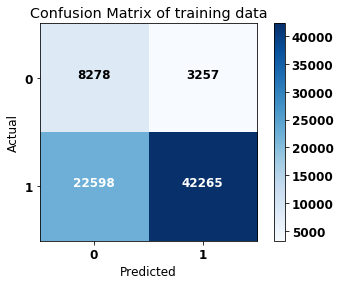

In [98]:
##https://www.kaggle.com/jprakashds/confusion-matrix-in-python-binary-class
import itertools
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix of training data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(y_test))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show();

In [99]:
y_pred = (clf.predict_proba(X_test_LR_TFIDF.toarray())[:,1] >= optimim_threshold)*1
cf=confusion_matrix(y_test,y_pred)

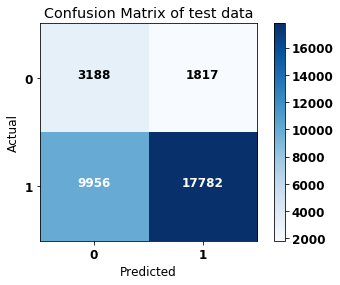

In [100]:
##https://www.kaggle.com/jprakashds/confusion-matrix-in-python-binary-class
import itertools
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix of test data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(y_test))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show();

## Wordcloud for False positive Essay

32743
1817


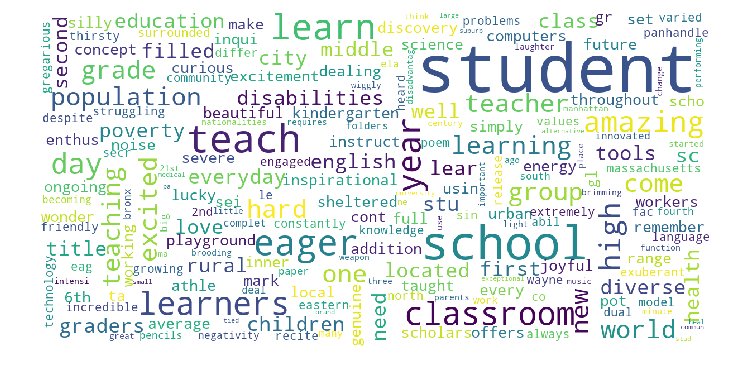

In [101]:
from wordcloud import WordCloud, STOPWORDS 

print(len(X_test))
# Saving all false positive test data
X_test_FP = X_test[(y_test == 0) & (y_pred == 1)]
print(len(X_test_FP))

stopwords = set(STOPWORDS)

#https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
  
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(X_test_FP['clean_essay'])
 

## Box Plot with for price of false positive data points

In [102]:
price_FP = X_test_FP['price'].values

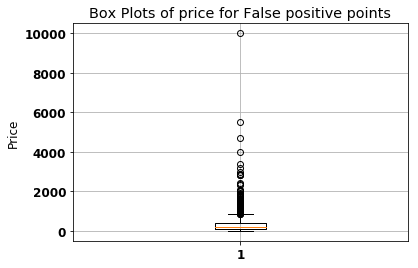

In [103]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot(price_FP)
plt.title('Box Plots of price for False positive points')
plt.ylabel('Price')
plt.grid()
plt.show()

## PDF with the teacher_number_of_previously_posted_projects of false positive data points

No handles with labels found to put in legend.


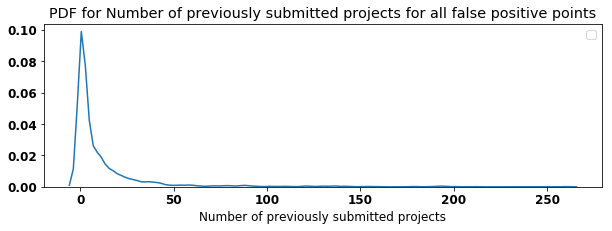

In [104]:
teacher_posted_projects_FP = X_test_FP['teacher_number_of_previously_posted_projects'].values
plt.figure(figsize=(10,3))
sns.distplot(teacher_posted_projects_FP, hist=False)
plt.title('PDF for Number of previously submitted projects for all false positive points')
plt.xlabel('Number of previously submitted projects')
plt.legend()
plt.show()

## Select 5000 best features using feature_importance

In [105]:
def selectKImportance(model, X, k):
     return X[:,model.feature_importances_.argsort()[::-1][:k]]

In [106]:
clf = DecisionTreeClassifier(class_weight='balanced',max_depth=clf_cv.best_params_.get('max_depth'),min_samples_split=clf_cv.best_params_.get('min_samples_split'))
clf.fit(X_tr_LR_TFIDF.toarray(),y_tr)
X_tr_LR_TFIDF_csr = X_tr_LR_TFIDF.tocsr()
X_tr_LR_TFIDF_selected = selectKImportance(clf,X_tr_LR_TFIDF_csr,5000)
X_tr_LR_TFIDF_selected.tocoo()
print(X_tr_LR_TFIDF_selected.shape)

X_test_LR_TFIDF_csr = X_test_LR_TFIDF.tocsr()
X_test_LR_TFIDF_selected = selectKImportance(clf,X_test_LR_TFIDF_csr,5000)
X_test_LR_TFIDF_selected.tocoo()
print(X_test_LR_TFIDF_selected.shape)


(76398, 5000)
(32743, 5000)


## Apply Logistic Regression on the 5000 selected features

The best value of AOC = 0.7013722370569303 is given by best lamda value of = 0.0001 


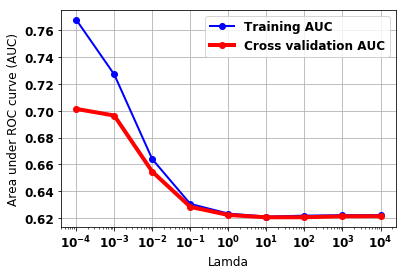

In [107]:
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

k=[ 0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

param_grid = {'alpha':[ 0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}

#Hyper parameter Tuning for lamda with 3 fold cross validation
clf = linear_model.SGDClassifier(loss='log',class_weight='balanced')

clf_cv= GridSearchCV(clf,param_grid,cv=3,scoring='roc_auc')

clf_cv.fit(X_tr_LR_TFIDF_selected.toarray(),y_tr)

print("The best value of AOC = {} is given by best lamda value of = {} ".format(clf_cv.best_score_,clf_cv.best_params_.get('alpha')))

#Plotting AUC

train_AUC=clf_cv.cv_results_['mean_train_score']

cv_AUC=clf_cv.cv_results_['mean_test_score']



pylab.plot(k, train_AUC, '-b', label='Training AUC',linewidth=2.0,marker='o')
pylab.plot(k, cv_AUC, '-r', label='Cross validation AUC',linewidth=4.0,marker='o')
pylab.legend(loc='upper right')
pylab.xlabel('Lamda')
pylab.ylabel('Area under ROC curve (AUC)')
pylab.xscale("log")
pylab.grid()
pylab.show()

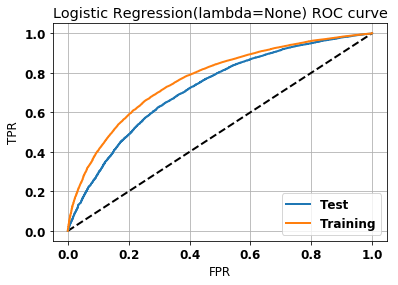

The Training AUC (area under curve) for hypertuned parameter lamda=0.0001 = 0.7670774073441218
The Test AUC (area under curve) for hypertuned parameter lambda=0.0001 = 0.7181030592451747


In [108]:
#Instantiate Classifier
clf = linear_model.SGDClassifier(loss='log',class_weight='balanced',alpha=clf_cv.best_params_.get('alpha'))
clf.fit(X_tr_LR_TFIDF_selected.toarray(),y_tr)
y_pred_proba_test = clf.predict_proba(X_test_LR_TFIDF_selected.toarray())[:,1]
y_pred_proba_tr = clf.predict_proba(X_tr_LR_TFIDF_selected.toarray())[:,1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_proba_test)
fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_tr, y_pred_proba_tr)
plt.plot([0,1],[0,1],'k--',linewidth=2.0)
plt.plot(fpr_test,tpr_test, label='Test',linewidth=2.0)
plt.plot(fpr_tr,tpr_tr, label='Training',linewidth=2.0)
plt.xlabel('FPR')
plt.ylabel('TPR')
pylab.legend(loc='lower right')
plt.title('Logistic Regression(lambda={}) ROC curve'.format(clf_cv.best_params_.get('n_neighbors')))
plt.grid()
plt.show()
#Area under ROC curve
print('The Training AUC (area under curve) for hypertuned parameter lamda={} = {}'.format(clf_cv.best_params_.get('alpha'),roc_auc_score(y_tr,y_pred_proba_tr)))
print('The Test AUC (area under curve) for hypertuned parameter lambda={} = {}'.format(clf_cv.best_params_.get('alpha'),roc_auc_score(y_test,y_pred_proba_test)))

test_AUC_TFIDF_LR = roc_auc_score(y_test,y_pred_proba_test)
training_AUC_TFIDF_LR = roc_auc_score(y_tr,y_pred_proba_tr)
k_TFIDF_LR = clf_cv.best_params_.get('alpha')

In [109]:
#https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
i = np.arange(0,len(tpr_tr)) 
roc = pd.DataFrame({'fpr' : pd.Series(fpr_tr, index=i),'tpr' : pd.Series(tpr_tr, index = i), '1-fpr' : pd.Series(1-fpr_tr, index = i), 'tf' : pd.Series(tpr_tr*(1-fpr_tr), index = i), 'thresholds' : pd.Series(thresholds_tr, index = i)})
roc.ix[(roc.tf-0).abs().argsort()[:1]]

index=roc['tf'].idxmax()

optimim_threshold=roc['thresholds'].iloc[index]
print(roc.iloc[index])
print(optimim_threshold)

fpr           0.280191
tpr           0.685368
1-fpr         0.719809
tf            0.493334
thresholds    0.514016
Name: 5886, dtype: float64
0.5140158262216299


In [110]:
y_pred = (clf.predict_proba(X_tr_LR_TFIDF_selected.toarray())[:,1] >= optimim_threshold)*1
cf=confusion_matrix(y_tr,y_pred)

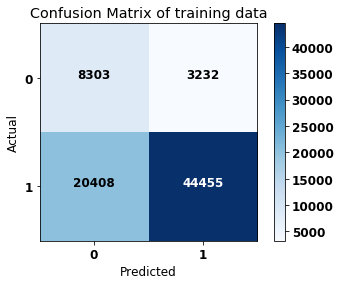

In [111]:
import itertools
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix of training data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(y_test))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show();

In [112]:
y_pred = (clf.predict_proba(X_test_LR_TFIDF_selected.toarray())[:,1] >= optimim_threshold)*1
cf=confusion_matrix(y_test,y_pred)

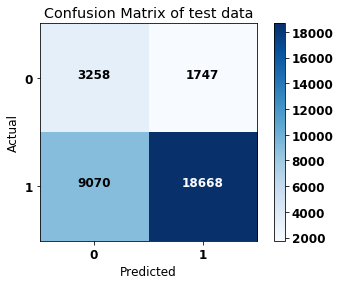

In [113]:
##https://www.kaggle.com/jprakashds/confusion-matrix-in-python-binary-class
import itertools
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix of test data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(y_test))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show();

####  Set 3: categorical, numerical features + project_title(AVG W2V) + preprocessed_essay (AVG W2V)

In [114]:
# First combine all features to create total matrix
X_tr_LR_avgw2v = hstack((Tr_quantity_standardized, Tr_teacher_number_of_previously_posted_projects_standardized,  
                       Tr_price_standardized,Tr_clean_subcategories_one_hot,Tr_clean_categories_one_hot, 
                       Tr_clean_grades_categories_one_hot,Tr_clean_teacher_prefix_one_hot,Tr_state_one_hot,
                       Tr_presence_of_numerical_digits_one_hot,   
                       Tr_avg_w2v_vectors_essay, Tr_avg_w2v_vectors_project_title))


X_test_LR_avgw2v = hstack((Test_quantity_standardized, Test_teacher_number_of_previously_posted_projects_standardized,  
                       Test_price_standardized,Test_clean_subcategories_one_hot,Test_clean_categories_one_hot, 
                       Test_clean_grades_categories_one_hot,Test_clean_teacher_prefix_one_hot,Test_state_one_hot,
                       Test_presence_of_numerical_digits_one_hot,Test_avg_w2v_vectors_essay, 
                       Test_avg_w2v_vectors_project_title))

print(X_tr_LR_avgw2v.shape)
print(X_test_LR_avgw2v.shape)

(76398, 204)
(32743, 204)


{'max_depth': 5, 'min_samples_split': 500}
0.6578551573231365


Text(0.5, 12.0, 'min_samples_split')

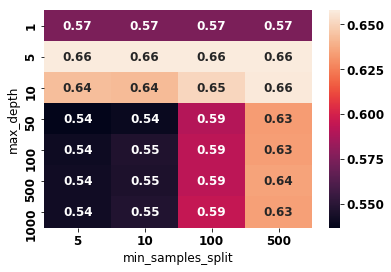

In [115]:
param_grid = {'max_depth':[ 1, 5, 10, 50, 100, 500, 1000],
              'min_samples_split':[5, 10, 100, 500]}

#Hyper parameter Tuning for lamda with 3 fold cross validation
clf = DecisionTreeClassifier()

clf_cv= GridSearchCV(clf,param_grid,cv=2,scoring='roc_auc')

clf_cv.fit(X_tr_LR_avgw2v.toarray(),y_tr)

print(clf_cv.best_params_)

print(clf_cv.best_score_)

#https://www.kaggle.com/jinilcs/grid-search-to-find-best-tuning-parameters
results_df = pd.DataFrame(clf_cv.cv_results_)

scores = np.array(results_df.mean_test_score).reshape(7, 4)

sns.heatmap(scores, annot=True, 
            yticklabels=param_grid['max_depth'], xticklabels=param_grid['min_samples_split'])
plt.ylabel('max_depth')
plt.xlabel('min_samples_split')


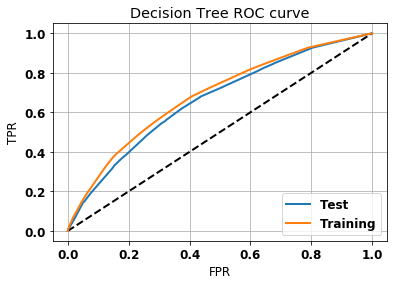

The Training AUC (area under curve) for hypertuned parameter maximum depth=5 and min_samples_split =500 = 0.6825074049408034
The Test AUC (area under curve) for hypertuned parameter maximum depth=5 and min_samples_split =500 = 0.6600198849387688


In [116]:
#Instantiate Classifier
clf = DecisionTreeClassifier(class_weight='balanced',max_depth=clf_cv.best_params_.get('max_depth'),min_samples_split=clf_cv.best_params_.get('min_samples_split'))
clf.fit(X_tr_LR_avgw2v.toarray(),y_tr)
y_pred_proba_test = clf.predict_proba(X_test_LR_avgw2v.toarray())[:,1]
y_pred_proba_tr = clf.predict_proba(X_tr_LR_avgw2v.toarray())[:,1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_proba_test)
fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_tr, y_pred_proba_tr)
plt.plot([0,1],[0,1],'k--',linewidth=2.0)
plt.plot(fpr_test,tpr_test, label='Test',linewidth=2.0)
plt.plot(fpr_tr,tpr_tr, label='Training',linewidth=2.0)
plt.xlabel('FPR')
plt.ylabel('TPR')
pylab.legend(loc='lower right')
plt.title('Decision Tree ROC curve')
plt.grid()
plt.show()
#Area under ROC curve
print('The Training AUC (area under curve) for hypertuned parameter maximum depth={} and min_samples_split ={} = {}'.format(clf_cv.best_params_.get('max_depth'),clf_cv.best_params_.get('min_samples_split'),roc_auc_score(y_tr,y_pred_proba_tr)))
print('The Test AUC (area under curve) for hypertuned parameter maximum depth={} and min_samples_split ={} = {}'.format(clf_cv.best_params_.get('max_depth'),clf_cv.best_params_.get('min_samples_split'),roc_auc_score(y_test,y_pred_proba_test)))

test_AUC_AVGW2V = roc_auc_score(y_test,y_pred_proba_test)
training_AUC_AVGW2V = roc_auc_score(y_tr,y_pred_proba_tr)
depth_AVGW2V = clf_cv.best_params_.get('max_depth')
split_AVGW2V = clf_cv.best_params_.get('min_samples_split')


#### Finding optimum threshold value

Finding optimum threshold using training data for high tpr and low fpr. For this we use maximum value of parameter tr=tpr*(1-fpr)

In [117]:
i = np.arange(0,len(tpr_tr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr_tr, index=i),'tpr' : pd.Series(tpr_tr, index = i), '1-fpr' : pd.Series(1-fpr_tr, index = i), 'tf' : pd.Series(tpr_tr*(1-fpr_tr), index = i), 'thresholds' : pd.Series(thresholds_tr, index = i)})
roc.ix[(roc.tf-0).abs().argsort()[:1]]

index=roc['tf'].idxmax()

optimim_threshold=roc['thresholds'].iloc[index]
print(roc.iloc[index])
print(optimim_threshold)

fpr           0.350845
tpr           0.622034
1-fpr         0.649155
tf            0.403796
thresholds    0.519292
Name: 18, dtype: float64
0.5192918534600441


In [118]:
y_pred = (clf.predict_proba(X_tr_LR_avgw2v.toarray())[:,1] >= optimim_threshold)*1
cf=confusion_matrix(y_tr,y_pred)

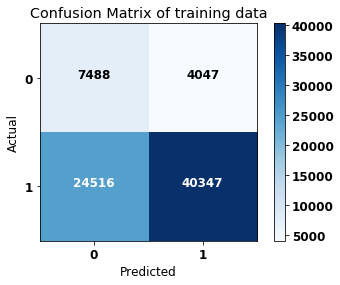

In [119]:
##https://www.kaggle.com/jprakashds/confusion-matrix-in-python-binary-class
import itertools
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix of training data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(y_test))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show();

In [120]:
y_pred = (clf.predict_proba(X_test_LR_avgw2v.toarray())[:,1] >= optimim_threshold)*1
cf=confusion_matrix(y_test,y_pred)

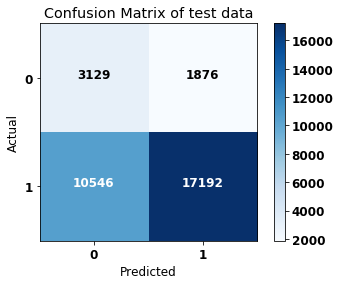

In [121]:
##https://www.kaggle.com/jprakashds/confusion-matrix-in-python-binary-class
import itertools
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix of test data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(y_test))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show();

## Wordcloud for False positive Essay

32743
1876


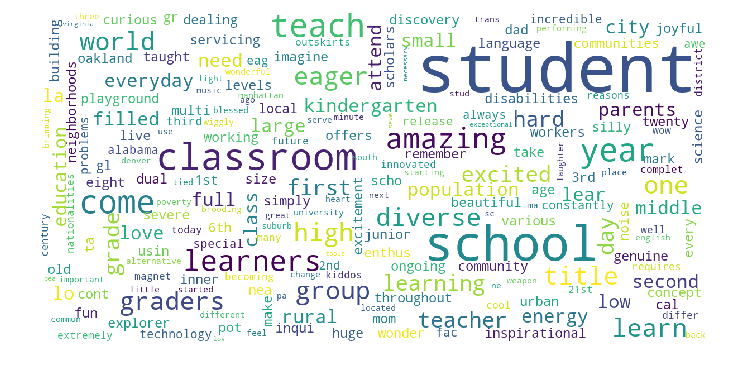

In [122]:
from wordcloud import WordCloud, STOPWORDS 

print(len(X_test))
# Saving all false positive test data
X_test_FP = X_test[(y_test == 0) & (y_pred == 1)]
print(len(X_test_FP))

stopwords = set(STOPWORDS)

#https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
  
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(X_test_FP['clean_essay'])
 

## Box Plot with for price of false positive data points

In [123]:
price_FP = X_test_FP['price'].values

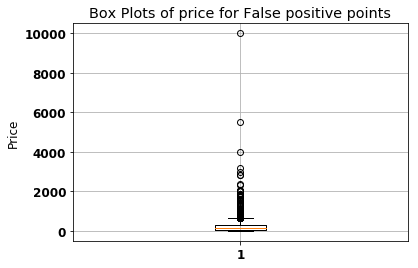

In [124]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot(price_FP)
plt.title('Box Plots of price for False positive points')
plt.ylabel('Price')
plt.grid()
plt.show()

## PDF with the teacher_number_of_previously_posted_projects of false positive data points

No handles with labels found to put in legend.


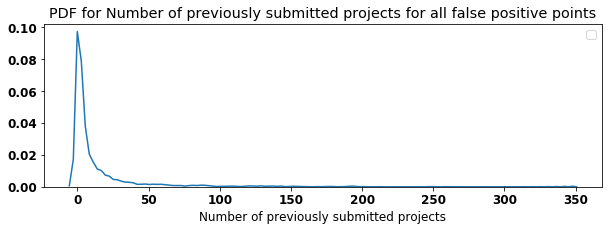

In [125]:
teacher_posted_projects_FP = X_test_FP['teacher_number_of_previously_posted_projects'].values
plt.figure(figsize=(10,3))
sns.distplot(teacher_posted_projects_FP, hist=False)
plt.title('PDF for Number of previously submitted projects for all false positive points')
plt.xlabel('Number of previously submitted projects')
plt.legend()
plt.show()

#### Set 4: categorical, numerical features + project_title(TFIDF W2V) + preprocessed_essay (TFIDF W2V)

In [126]:
# First combine all features to create total matrix
X_tr_LR_tfidfw2v = hstack((Tr_quantity_standardized, Tr_teacher_number_of_previously_posted_projects_standardized,  
                       Tr_price_standardized,Tr_clean_subcategories_one_hot,Tr_clean_categories_one_hot, 
                       Tr_clean_grades_categories_one_hot,Tr_clean_teacher_prefix_one_hot,Tr_state_one_hot,
                       Tr_presence_of_numerical_digits_one_hot,tr_tfidf_w2v_vectors_essay, tr_tfidf_w2v_vectors_project_title))


X_test_LR_tfidfw2v = hstack((Test_quantity_standardized, Test_teacher_number_of_previously_posted_projects_standardized,  
                       Test_price_standardized,Test_clean_subcategories_one_hot,Test_clean_categories_one_hot, 
                       Test_clean_grades_categories_one_hot,Test_clean_teacher_prefix_one_hot,Test_state_one_hot,
                       Test_presence_of_numerical_digits_one_hot,Test_tfidf_w2v_vectors_essay, 
                       Test_tfidf_w2v_vectors_project_title))

print(X_tr_LR_tfidfw2v.shape)
print(X_test_LR_tfidfw2v.shape)

(76398, 204)
(32743, 204)


{'max_depth': 5, 'min_samples_split': 500}
0.6613760986655589


Text(0.5, 12.0, 'min_samples_split')

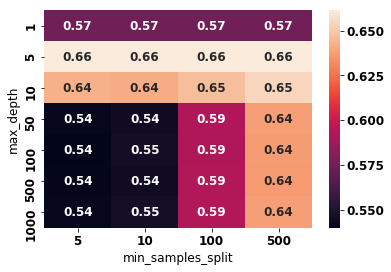

In [127]:
param_grid = {'max_depth':[ 1, 5, 10, 50, 100, 500, 1000],
              'min_samples_split':[5, 10, 100, 500]}

#Hyper parameter Tuning for lamda with 3 fold cross validation
clf = DecisionTreeClassifier()

clf_cv= GridSearchCV(clf,param_grid,cv=2,scoring='roc_auc')

clf_cv.fit(X_tr_LR_tfidfw2v.toarray(),y_tr)

print(clf_cv.best_params_)

print(clf_cv.best_score_)

#https://www.kaggle.com/jinilcs/grid-search-to-find-best-tuning-parameters
results_df = pd.DataFrame(clf_cv.cv_results_)

scores = np.array(results_df.mean_test_score).reshape(7, 4)

sns.heatmap(scores, annot=True, 
            yticklabels=param_grid['max_depth'], xticklabels=param_grid['min_samples_split'])
plt.ylabel('max_depth')
plt.xlabel('min_samples_split')


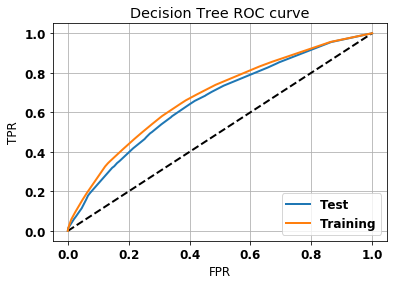

The Training AUC (area under curve) for hypertuned parameter maximum depth=5 and min_samples_split =500 = 0.6812332753678069
The Test AUC (area under curve) for hypertuned parameter maximum depth=5 and min_samples_split =500 = 0.6581967243226166


In [128]:
#Instantiate Classifier
clf = DecisionTreeClassifier(class_weight='balanced',max_depth=clf_cv.best_params_.get('max_depth'),min_samples_split=clf_cv.best_params_.get('min_samples_split'))
clf.fit(X_tr_LR_tfidfw2v.toarray(),y_tr)
y_pred_proba_test = clf.predict_proba(X_test_LR_tfidfw2v.toarray())[:,1]
y_pred_proba_tr = clf.predict_proba(X_tr_LR_tfidfw2v.toarray())[:,1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_proba_test)
fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_tr, y_pred_proba_tr)
plt.plot([0,1],[0,1],'k--',linewidth=2.0)
plt.plot(fpr_test,tpr_test, label='Test',linewidth=2.0)
plt.plot(fpr_tr,tpr_tr, label='Training',linewidth=2.0)
plt.xlabel('FPR')
plt.ylabel('TPR')
pylab.legend(loc='lower right')
plt.title('Decision Tree ROC curve')
plt.grid()
plt.show()
#Area under ROC curve
print('The Training AUC (area under curve) for hypertuned parameter maximum depth={} and min_samples_split ={} = {}'.format(clf_cv.best_params_.get('max_depth'),clf_cv.best_params_.get('min_samples_split'),roc_auc_score(y_tr,y_pred_proba_tr)))
print('The Test AUC (area under curve) for hypertuned parameter maximum depth={} and min_samples_split ={} = {}'.format(clf_cv.best_params_.get('max_depth'),clf_cv.best_params_.get('min_samples_split'),roc_auc_score(y_test,y_pred_proba_test)))

test_AUC_TFIDFW2V = roc_auc_score(y_test,y_pred_proba_test)
training_AUC_TFIDFW2V = roc_auc_score(y_tr,y_pred_proba_tr)
depth_TFIDFW2V = clf_cv.best_params_.get('max_depth')
split_TFIDFW2V = clf_cv.best_params_.get('min_samples_split')


#### Finding optimum threshold value

Finding optimum threshold using training data for high tpr and low fpr. For this we use maximum value of parameter tr=tpr*(1-fpr)

In [129]:
i = np.arange(0,len(tpr_tr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr_tr, index=i),'tpr' : pd.Series(tpr_tr, index = i), '1-fpr' : pd.Series(1-fpr_tr, index = i), 'tf' : pd.Series(tpr_tr*(1-fpr_tr), index = i), 'thresholds' : pd.Series(thresholds_tr, index = i)})
roc.ix[(roc.tf-0).abs().argsort()[:1]]

index=roc['tf'].idxmax()

optimim_threshold=roc['thresholds'].iloc[index]
print(roc.iloc[index])
print(optimim_threshold)

fpr           0.370091
tpr           0.643063
1-fpr         0.629909
tf            0.405071
thresholds    0.506489
Name: 22, dtype: float64
0.5064887420408352


In [130]:
y_pred = (clf.predict_proba(X_tr_LR_tfidfw2v.toarray())[:,1] >= optimim_threshold)*1
cf=confusion_matrix(y_tr,y_pred)

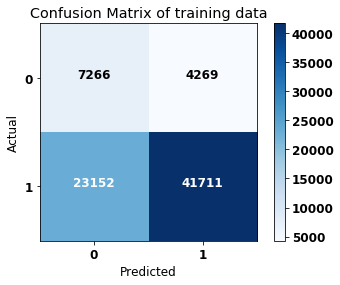

In [131]:
##https://www.kaggle.com/jprakashds/confusion-matrix-in-python-binary-class
import itertools
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix of training data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(y_test))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show();

In [132]:
y_pred = (clf.predict_proba(X_test_LR_tfidfw2v.toarray())[:,1] >= optimim_threshold)*1
cf=confusion_matrix(y_test,y_pred)

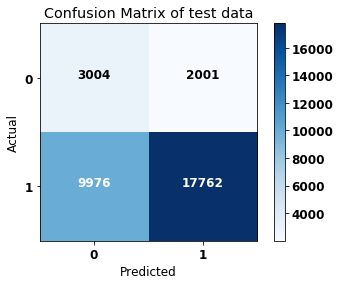

In [133]:
##https://www.kaggle.com/jprakashds/confusion-matrix-in-python-binary-class
import itertools
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix of test data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(y_test))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show();

## Wordcloud for False positive Essay

32743
2001


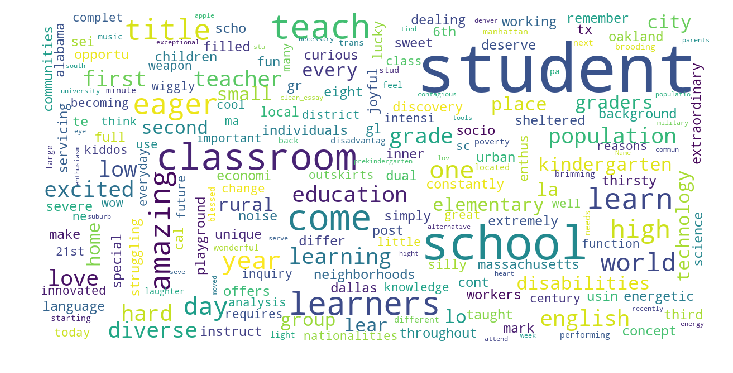

In [134]:
from wordcloud import WordCloud, STOPWORDS 

print(len(X_test))
# Saving all false positive test data
X_test_FP = X_test[(y_test == 0) & (y_pred == 1)]
print(len(X_test_FP))

stopwords = set(STOPWORDS)

#https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
  
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(X_test_FP['clean_essay'])
 

## Box Plot with for price of false positive data points

In [135]:
price_FP = X_test_FP['price'].values

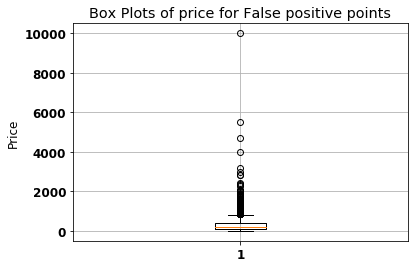

In [136]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot(price_FP)
plt.title('Box Plots of price for False positive points')
plt.ylabel('Price')
plt.grid()
plt.show()

## PDF with the teacher_number_of_previously_posted_projects of false positive data points

No handles with labels found to put in legend.


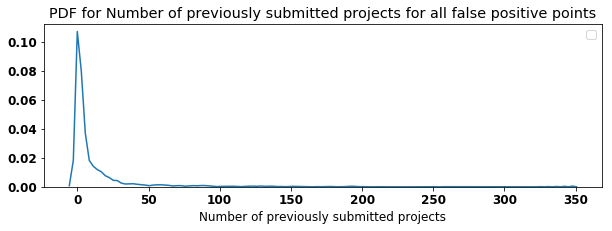

In [137]:
teacher_posted_projects_FP = X_test_FP['teacher_number_of_previously_posted_projects'].values
plt.figure(figsize=(10,3))
sns.distplot(teacher_posted_projects_FP, hist=False)
plt.title('PDF for Number of previously submitted projects for all false positive points')
plt.xlabel('Number of previously submitted projects')
plt.legend()
plt.show()

## 9. Summarising results

In [138]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Max_depth","min_samples_split","Test score (AUC)","Training score (AUC)"]

x.add_row(["BOW", "Decision Tree", depth_BOW,split_BOW, test_AUC_BOW,training_AUC_BOW])
x.add_row(["TFIDF", "Decision Tree", depth_TFIDF,split_TFIDF, test_AUC_TFIDF,training_AUC_TFIDF])
x.add_row(["AVG W2V", "Decision Tree", depth_AVGW2V,split_AVGW2V, test_AUC_AVGW2V,training_AUC_AVGW2V])
x.add_row(["TFIDF W2V", "Decision Tree", depth_TFIDFW2V,split_TFIDFW2V, test_AUC_TFIDFW2V,training_AUC_TFIDFW2V])


print(x)

from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "lamda","Test score (AUC)","Training score (AUC)"]

x.add_row(["TFIDF with 5000 selected features", "Logistic Regression", k_TFIDF_LR , test_AUC_TFIDF_LR,training_AUC_TFIDF_LR])


print(x)


+------------+---------------+-----------+-------------------+--------------------+----------------------+
| Vectorizer |     Model     | Max_depth | min_samples_split |  Test score (AUC)  | Training score (AUC) |
+------------+---------------+-----------+-------------------+--------------------+----------------------+
|    BOW     | Decision Tree |     10    |        500        | 0.6825737208929942 |  0.7362523843308941  |
|   TFIDF    | Decision Tree |     10    |        500        | 0.6824250052348689 |  0.7478566371303043  |
|  AVG W2V   | Decision Tree |     5     |        500        | 0.6600198849387688 |  0.6825074049408034  |
| TFIDF W2V  | Decision Tree |     5     |        500        | 0.6581967243226166 |  0.6812332753678069  |
+------------+---------------+-----------+-------------------+--------------------+----------------------+
+-----------------------------------+---------------------+--------+--------------------+----------------------+
|             Vectorizer       

## 10. Conclusion

1. Since we used class_weight ='balanced' now our confusion matrix is not baised towards majority class.
2. Although the time complexity of training phase is O(n* k* d) where n is the number of data points and k is the dimension and is the depth of the tree, the time complexity of test phase is just O(d). Therefore with two parameters to fit, it takes lot of time during training phase but is very quick for test phase for resonable depth.
3. Since we have done tuning of parameter using cross validation therefore we are not under or over fitting.
4. For DT, as the depth of the tree increases the impact of outliers increases however here since we obtain resonable depth using tuning therefore we should be affected by outliers.
5. We found 5000 best features using DT and fitted Logistic regression on it. This lead to imporvement of result.
6. DT have good interpretability of results specially for small depths.